### 1. Loding Required Libraries

In [560]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### 2. About Dataset

#### 2.1 Loading Dataset into Pandas DataFrame

In [561]:
data = pd.read_csv("../datasets/indian_liver_patient.csv")
data.head()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,1


#### 2.2 Number of Row and Columns

In [562]:
rows = data.shape[0]
cols = data.shape[1]

print(f"This dataset has \033[1m {rows} rows\033[0m and \033[1m{cols} columns \033[0m.")

This dataset has  583 rows and 11 columns .


#### 2.3 Null Values in Dataset

In [563]:
[[features, data[features].isnull().sum()] for features in data.columns if data[features].isnull().sum() > 0]

[['Albumin_and_Globulin_Ratio', 4]]

#### 2.4 Heatmap of Missing Values

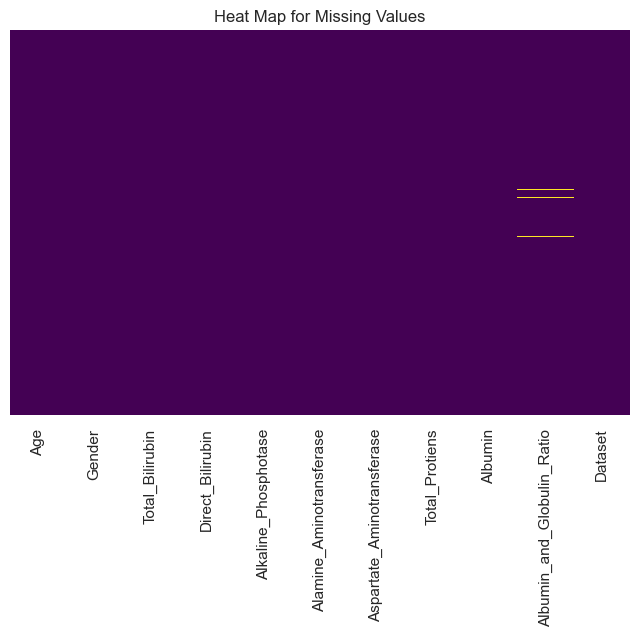

In [564]:
fig = sns.set(rc={'figure.figsize': (8, 5)})
plt.title("Heat Map for Missing Values")
sns.heatmap(data.isnull(), yticklabels = False, cbar = False, cmap = 'viridis')
plt.show()

**Observation**

As there are only four Missing Values in **Albumin_and_Globulin_Ratio** column, heance we will drop them.

#### 2.5 Drop Na Values

In [565]:
data.dropna(inplace=True)

#### 2.6 Setting Proper Target Values

In [566]:
data.loc[:, "Dataset"] = data.loc[:, "Dataset"].map({1:0, 2:1})

#### 2.7 Co-relation

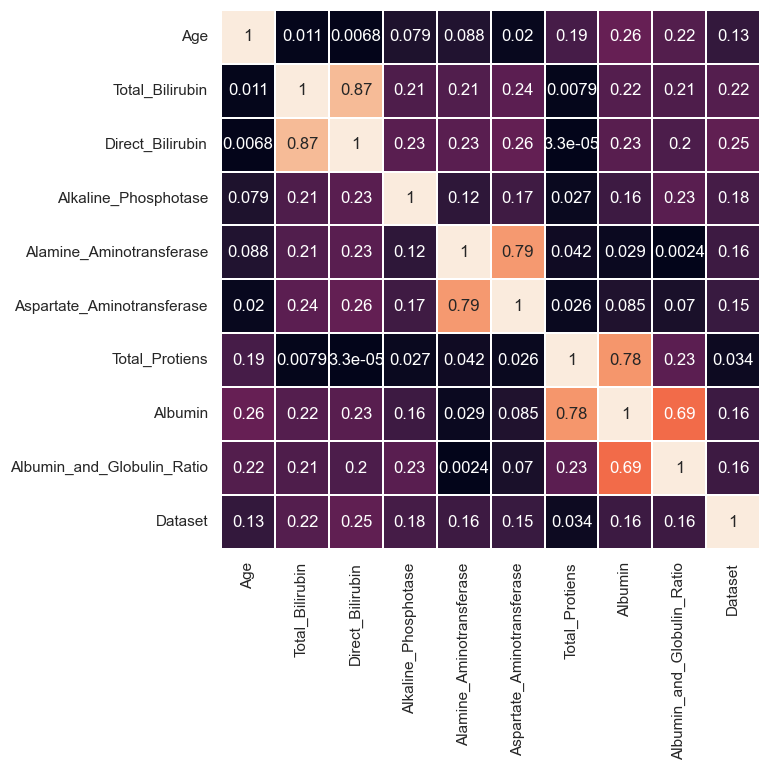

In [567]:
fig, ax = plt.subplots(figsize=(7,7))
sns.heatmap(abs(data.drop(data.loc[:,"Gender"].name, axis=1).corr()), annot=True, square=True, cbar=False, ax=ax, linewidths=0.25)
plt.show()

### 3. Modeling

#### 3.1 Analyzing Target 

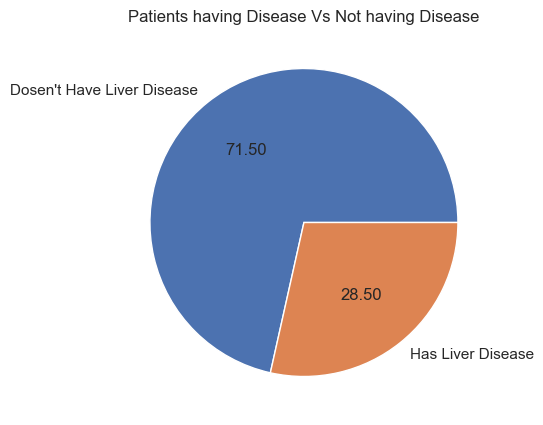

In [568]:
fig = sns.set(rc={'figure.figsize': (5, 5)})
plt.title("Patients having Disease Vs Not having Disease")
plt.pie(data['Dataset'].value_counts(),labels=data['Dataset'].map({0:"Dosen't Have Liver Disease", 1: "Has Liver Disease"}).unique(), autopct='%.2f')
plt.show()

#### 3.2 Import Required Libraries for Modeling

In [569]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score, confusion_matrix
from numpy import sqrt, argmax

#### 3.4 Pipeline

##### 3.4.1 One Hot Encoding

In [570]:
ohe = OneHotEncoder()
ohe.fit(data[['Gender']])

OneHotEncoder()

In [571]:
column_trans = make_column_transformer(
    (OneHotEncoder(categories=ohe.categories_),['Gender']),
    remainder='passthrough'
)

##### 3.4.2 Scaling

In [572]:
scaler = StandardScaler(with_mean=False)
# scaler = MinMaxScaler()

##### 3.4.3 Classification Models

In [573]:
lr = LogisticRegression()
rfc = RandomForestClassifier(
    max_depth=5, 
    n_estimators=10
)

##### 3.4.4 Pipe Structure

In [574]:
pipe = make_pipeline(column_trans, scaler, rfc)
pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(categories=[array(['Female', 'Male'], dtype=object)]),
                                                  ['Gender'])])),
                ('standardscaler', StandardScaler(with_mean=False)),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=5, n_estimators=10))])

#### 3.5 Trainer Function

In [575]:
def trainer(data, Target, oversample, test_size, pipe):

    if oversample:
        # Class count
        class_count = data[Target].value_counts()

        # for oversampling getting the max count
        max_class = max(class_count)

        # Divide DataFrame by Dataset
        df_class_0 = data[data[Target] == 0]
        df_class_1 = data[data[Target] == 1]

        #Oversampling
        df_class_0_over = df_class_0.sample(max_class,replace = True)
        df_class_1_over = df_class_1.sample(max_class,replace = True)

        data = pd.concat([df_class_0_over, df_class_1_over], axis = 0)
        print("Done Oversampling.")

    plt. figure(figsize=(3,3))
    data[Target].value_counts().plot(kind='bar', title='Count (target)')
    plt.show()

    # Split into Dependent and Independent
    X = data.drop('Dataset', axis=1)
    y = data['Dataset']
    print("Splitted data into X and Y.")
    
    X_train, x_test, Y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    print("Splitted data into Train and Test.")

    pipe.fit(X_train, Y_train)
    print("Model Fit Successfully!")
    
    y_pred = pipe.predict(x_test)

    y_pred_prob = pipe.predict_proba(x_test)
    
    roc_auc = round(roc_auc_score(y_test, y_pred_prob[:, 1]), 2)

    print(f"\n\033[1mROC-AUC Score\033[0m \t\t: {roc_auc*100} %")

    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:,1], pos_label=1)
        
    # calculate the g-mean for each threshold
    gmeans = sqrt(tpr * (1-fpr))

    # locate the index of the largest g-mean
    ix = argmax(gmeans)
    print('\033[1mBest Threshold\033[0m \t\t: %.3f' % (thresholds[ix]))
    print('\033[1mG-Mean\033[0m \t\t\t: %.3f' % (gmeans[ix]))

    y_pred = (y_pred > thresholds[ix])

    accuracy = accuracy_score(y_test, y_pred)
    print("\033[1mModel Accuracy\033[0m \t\t:", round(accuracy,2,)*100, "%")

    print("\033[1m\nClassification Report:\033[0m")
    print(classification_report(y_test, y_pred))

    plt.figure()
    plt.plot(fpr, tpr, label='(area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()

    fig = sns.set(rc={'figure.figsize': (5, 5)})
    plt.title("Confusion Matrix")
    cm=confusion_matrix(y_test, y_pred)
    sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('Truth')
    plt.ylabel('Prediction')
    plt.show()

    return pipe    

### 4. Experiments

#### 4.1 Experiment Number 1

Done Oversampling.


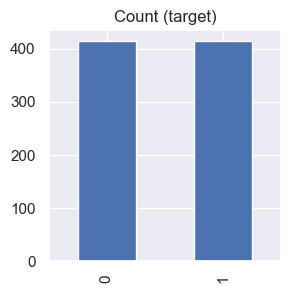

Splitted data into X and Y.
Splitted data into Train and Test.
Model Fit Successfully!

ROC-AUC Score 		: 92.0 %
Best Threshold 		: 0.617
G-Mean 			: 0.854
Model Accuracy 		: 84.0 %

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.76      0.82        38
           1       0.82      0.91      0.86        45

    accuracy                           0.84        83
   macro avg       0.85      0.84      0.84        83
weighted avg       0.85      0.84      0.84        83



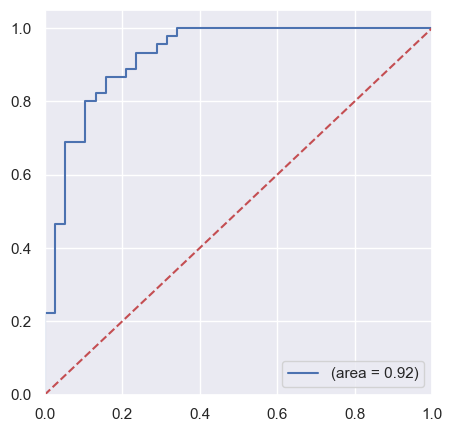

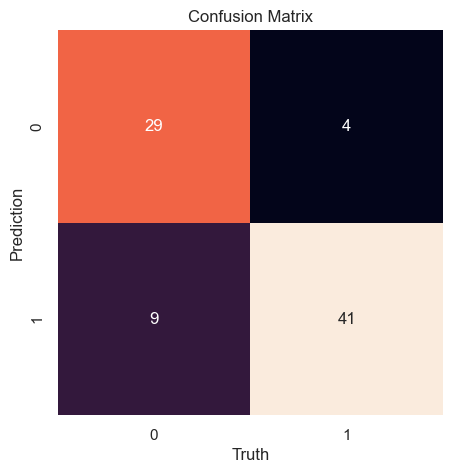

In [576]:
pipe = trainer(
    data=data, 
    Target='Dataset', 
    oversample=True, 
    test_size=0.1,
    pipe=pipe
)

#### 4.2 Experiment Number 2

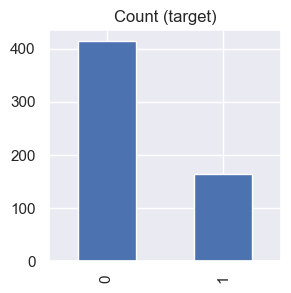

Splitted data into X and Y.
Splitted data into Train and Test.
Model Fit Successfully!

ROC-AUC Score 		: 73.0 %
Best Threshold 		: 0.162
G-Mean 			: 0.691
Model Accuracy 		: 72.0 %

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.93      0.82       201
           1       0.62      0.27      0.37        89

    accuracy                           0.72       290
   macro avg       0.68      0.60      0.60       290
weighted avg       0.70      0.72      0.69       290



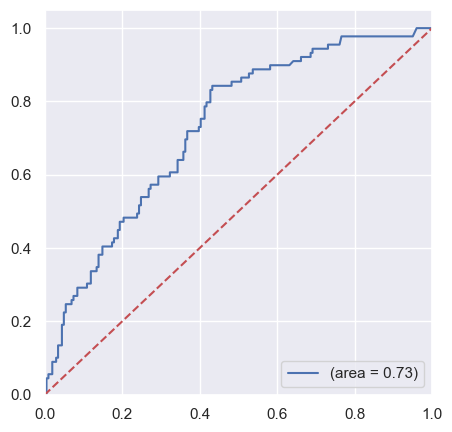

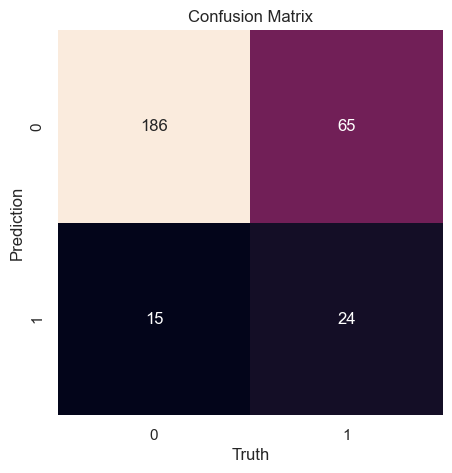

In [577]:
pipe = trainer(
    data=data, 
    Target='Dataset', 
    oversample=False, 
    test_size=0.5,
    pipe=pipe
)

#### 4.3 Experiment Number 3

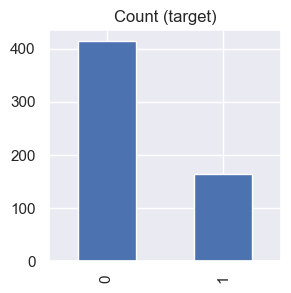

Splitted data into X and Y.
Splitted data into Train and Test.
Model Fit Successfully!

ROC-AUC Score 		: 76.0 %
Best Threshold 		: 0.241
G-Mean 			: 0.720
Model Accuracy 		: 62.0 %

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.93      0.76        73
           1       0.44      0.09      0.15        43

    accuracy                           0.62       116
   macro avg       0.54      0.51      0.45       116
weighted avg       0.56      0.62      0.53       116



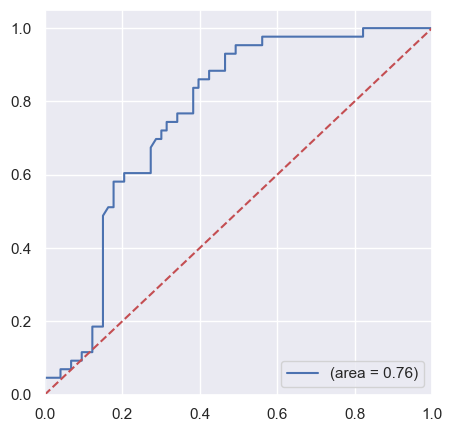

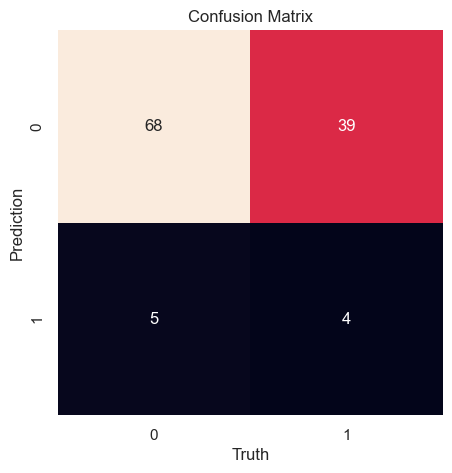

In [578]:
pipe = trainer(
    data=data, 
    Target='Dataset', 
    oversample=False, 
    test_size=0.2,
    pipe=pipe
)

#### 4.4 Experiment Number 4

Done Oversampling.


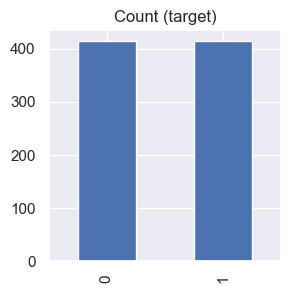

Splitted data into X and Y.
Splitted data into Train and Test.
Model Fit Successfully!

ROC-AUC Score 		: 85.0 %
Best Threshold 		: 0.530
G-Mean 			: 0.778
Model Accuracy 		: 74.0 %

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.67      0.73       210
           1       0.71      0.82      0.76       204

    accuracy                           0.74       414
   macro avg       0.75      0.75      0.74       414
weighted avg       0.75      0.74      0.74       414



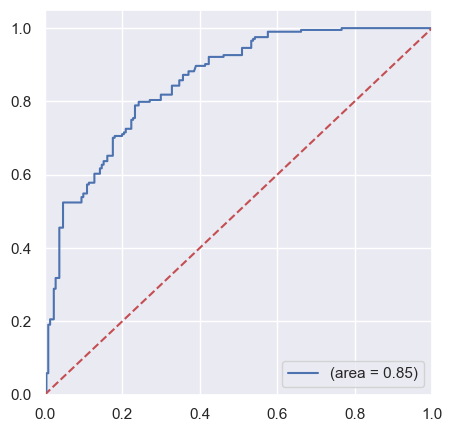

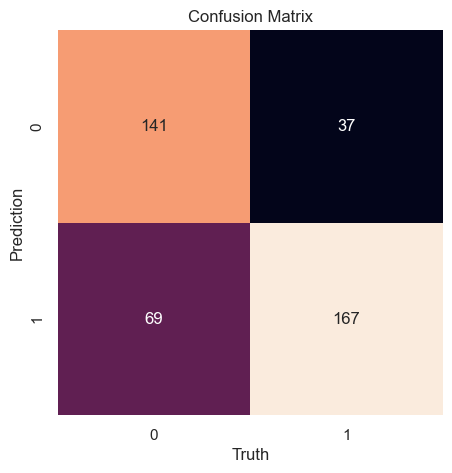

In [579]:
pipe = trainer(
    data=data, 
    Target='Dataset', 
    oversample=True, 
    test_size=0.5,
    pipe=pipe
)

### 5. Saving the Model

In [581]:
import pickle

save_data = {"model": pipe}

pickle.dump(save_data,open('../pickle/Model.pkl','wb'))